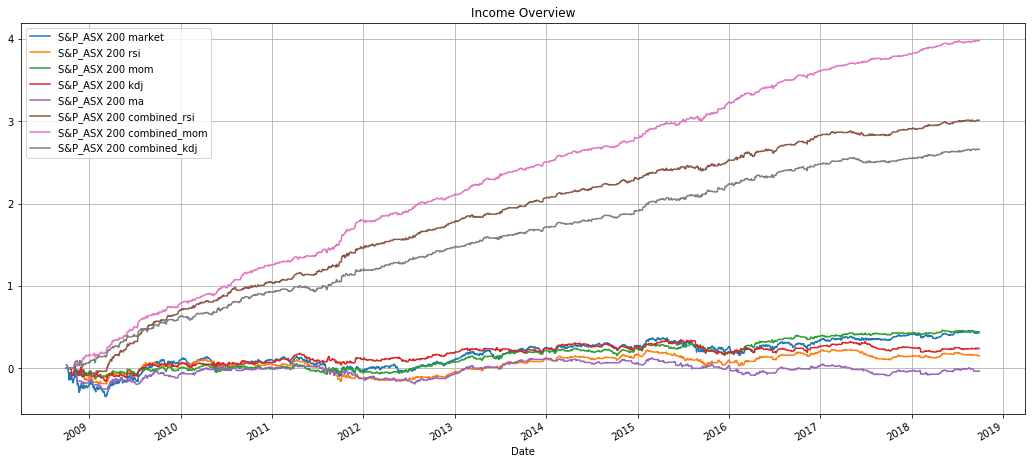

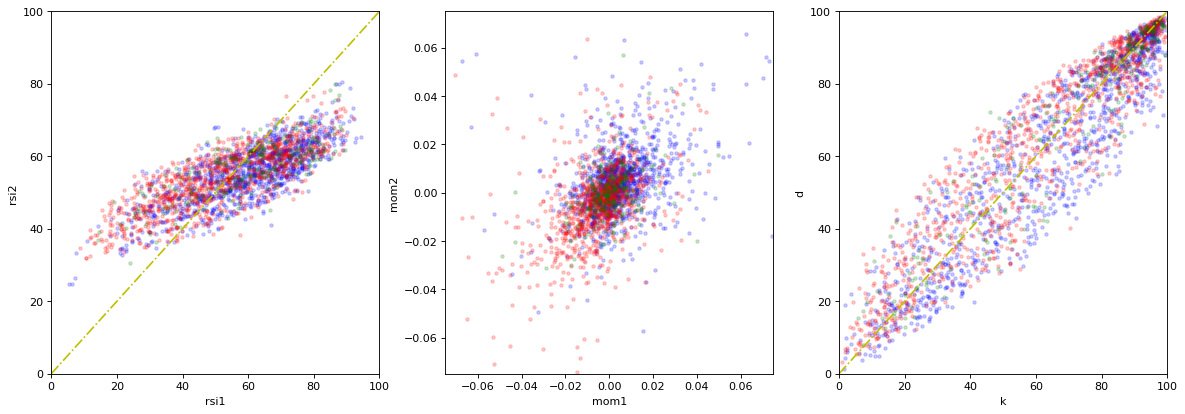

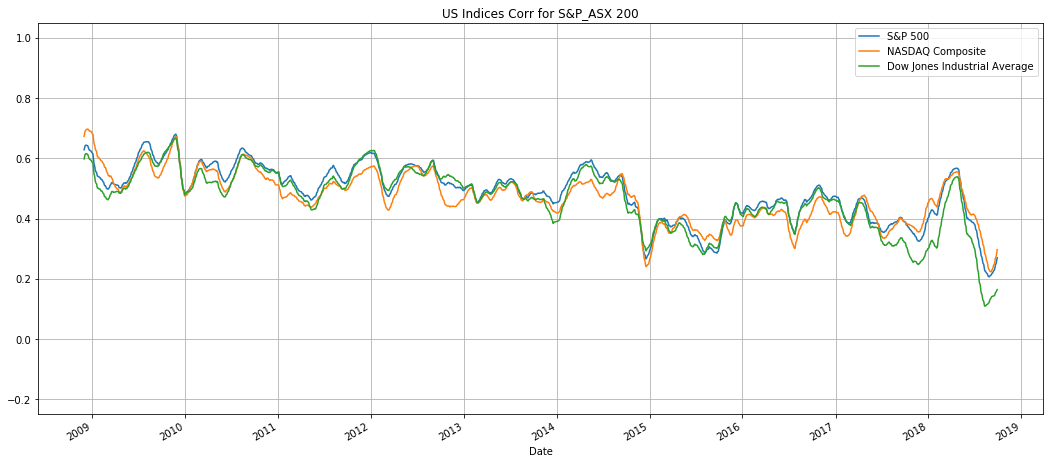

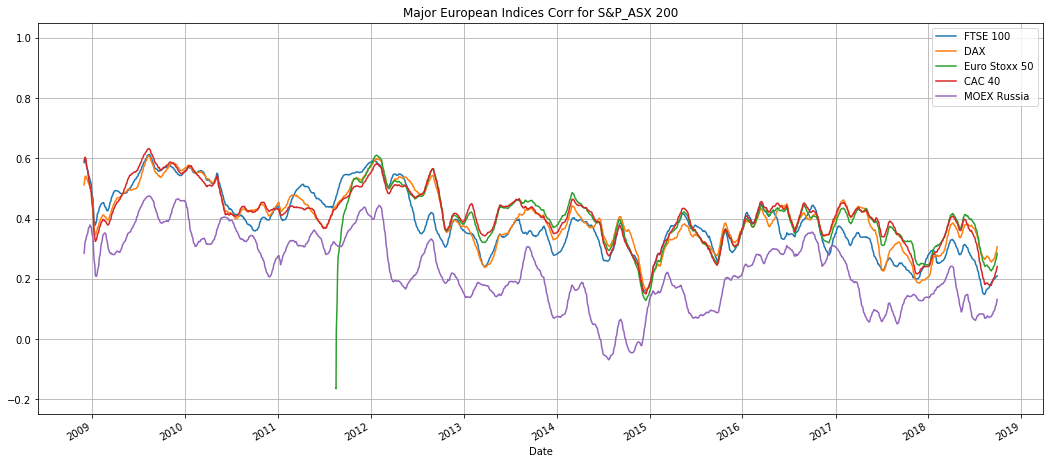

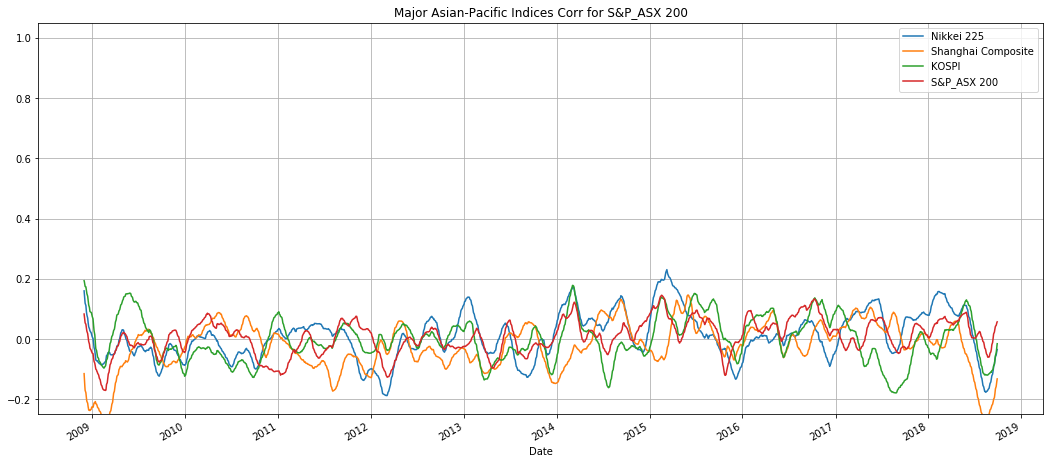

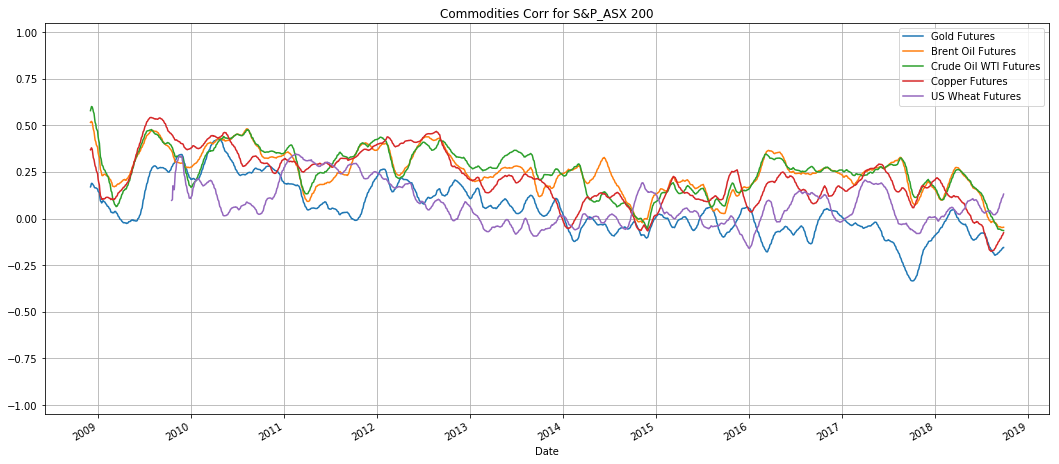

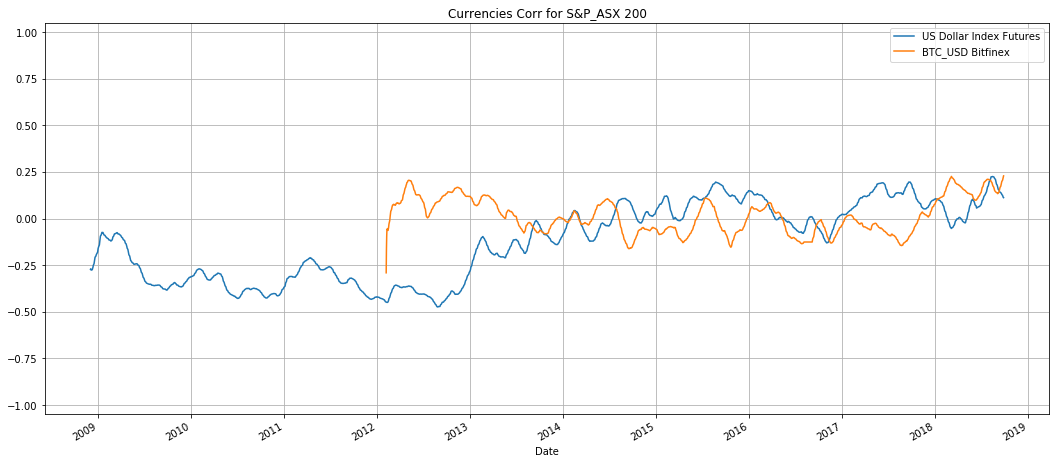

In [4]:
import csv
import numpy as np
import pandas as pd
import math
import talib
import matplotlib.pyplot as plt
%matplotlib inline

#main_index_set = ['S&P 500', 'NASDAQ Composite', 'Dow Jones Industrial Average', 'FTSE 100', 'DAX', 'CAC 40', 'MOEX Russia', 'Nikkei 225', 'Shanghai Composite', 'KOSPI', 'S&P_ASX 200']
main_index_set = ['S&P_ASX 200']
for main_index in main_index_set:
    period = 22

    def apply_signal(signal, change):
        income = change*signal.shift(1)
        return income.cumsum()

    def get_data(file_name):
        #读取数据并格式化
        data = pd.read_csv(r'd:\\data\\' + file_name + ' Historical Data.csv', thousands=',')
        #data = data[:500]
        data['Date'] = pd.to_datetime(data['Date'])
        #data['Price'].interpolate()
        data = data.set_index(data['Date'])
        data = data.sort_index(ascending=True)
        #计算日收益
        data['change'] = data['Price']/data['Price'].shift(1) -1.0
        data['market_income_sum'] = data['change'].shift(1).cumsum()

        #相对强度指标
        data['rsi1'] = talib.RSI(np.array(data['Price']), timeperiod=6)
        data['rsi2'] = talib.RSI(np.array(data['Price']), timeperiod=24)
        data['rsi_signal'] = np.where((data['rsi2']<data['rsi1']) & (data['rsi1']>0), 1, 0)
        data['rsi_income_sum'] = apply_signal(data['rsi_signal'], data['change'])
        #KDJ指标
        data['kdjk'],data['kdjd'] = talib.STOCH(np.array(data['High']),np.array(data['Low']),np.array(data['Price']), \
        fastk_period=9,slowk_period=3,slowk_matype=0,slowd_period=3,slowd_matype=0)
        data['kdj_signal'] = np.where((data['kdjk']>data['kdjd']) & (data['kdjd']>0), 1, 0)
        data['kdj_income_sum'] = apply_signal(data['kdj_signal'], data['change'])
        #动量指标
        data['mom1'] = talib.MOM(np.array(data['change']), timeperiod=5)
        data['mom2'] = talib.MOM(np.array(data['change']), timeperiod=22)
        data['mom_signal'] = np.where(data['mom1']+data['mom2'] >0, 1, 0)
        data['mom_income_sum'] = apply_signal(data['mom_signal'], data['change'])
        #均线与指数均线
        data['ma1'] = talib.MA(np.array(data['Price']), timeperiod=6)
        data['ma2'] = talib.MA(np.array(data['Price']), timeperiod=12)
        data['ma_signal'] = np.where(data['ma1']-data['ma2'] >0, 1, 0)
        data['ma_income_sum'] = apply_signal(data['ma_signal'], data['change'])
        data['ema1'] = talib.EMA(np.array(data['Price']), timeperiod=6)
        data['ema2'] = talib.EMA(np.array(data['Price']), timeperiod=12)
        return data

    #协方差相关系数
    def get_corr3(ref_data): 
        Main_index_data['ref'] = ref_data['change'].shift(1)
        Main_index_data['ref'].replace(np.nan, 0.0, inplace=True)
        Main_index_data['ref_sd'] = np.sqrt((Main_index_data['ref']*Main_index_data['ref']).rolling(window = period).mean())
        Main_index_data['base_sd'] = np.sqrt((Main_index_data['change'].shift(0)* Main_index_data['change'].shift(0)).rolling(window = period).mean())
        Main_index_data['cov_sd'] = (Main_index_data['ref_sd']*Main_index_data['base_sd'])
        Main_index_data['corr3'] =  (Main_index_data['ref'] * Main_index_data['change'].shift(0)).rolling(window = period).mean()/Main_index_data['cov_sd']
        return  Main_index_data['corr3']

    #信号化
    def sgn(data):
        new = data
        new = np.where(data>0, 1, 0)
        new = np.where(data<0, -1, new)
        return new

    #日收益信号化后的协方差相关系数
    def get_corr4(ref_data):
        Main_index_data['ref'] = ref_data['change']
        Main_index_data['ref'].replace(np.nan, 0.0, inplace=True)
        Main_index_data['ref'] = sgn(Main_index_data['ref'])
        Main_index_data['base']  =  sgn(Main_index_data['change'])
        Main_index_data['corr4'] =  (Main_index_data['ref'] * Main_index_data['base'].shift(0)).rolling(window = period).mean()
        #return Main_index_data['cov_sd'] 
        return  Main_index_data['corr4']

    #加权信号收益
    def get_combined_income_sum(file_name_set, strategy):
        Main_index_data['total_signal'] = Main_index_data['change']*0.0
        Main_index_data['total_weight'] = Main_index_data['change']*0.0
        for file_name in file_name_set:
            Main_index_data[file_name+' signal'] = Signal[file_name+' '+strategy]
            Main_index_data[file_name+' signal'].fillna(0)
            Main_index_data[file_name+' weight'] = Corelation3[file_name]        
            Main_index_data[file_name+' weight'].fillna(0)
            Main_index_data['total_signal'] += Main_index_data[file_name + ' signal']*Main_index_data[file_name+' weight']#/Corelation3[file_name].mean()*0.5
            Main_index_data['total_weight'] += Main_index_data[file_name+' weight']
        Main_index_data['total_signal'] = Main_index_data['total_signal']/Main_index_data['total_weight']
        Main_index_data['total_signal'] = np.where(Main_index_data['total_signal']>0.5, 1, 0)
        return apply_signal(Main_index_data['total_signal'], Main_index_data['change'])

    def add_index(file_name):
        new_data =  get_data(file_name)
        Corelation3[file_name] = get_corr3(new_data)
        Corelation3_show[file_name] = Corelation3[file_name].ewm(span = 126).mean()
        Corelation4[file_name] = get_corr4(new_data)    
        Corelation4_show[file_name] = Corelation4[file_name].ewm(span = 126).mean()
        Overview[file_name] = new_data['Price']
        Change[file_name] = new_data['change']
        Income[file_name+' market'] = new_data['market_income_sum']

        Income[file_name+' rsi'] = new_data['rsi_income_sum']
        Signal[file_name+' rsi'] = new_data['rsi_signal']
        Overview[file_name+' rsi1'] = new_data['rsi1']
        Overview[file_name+' rsi2'] = new_data['rsi2']    

        Income[file_name+' kdj'] = new_data['kdj_income_sum']
        Signal[file_name+' kdj'] = new_data['kdj_signal']
        Overview[file_name+' k'] = new_data['kdjk']
        Overview[file_name+' d'] = new_data['kdjd']

        Income[file_name+' mom'] = new_data['mom_income_sum']
        Signal[file_name+' mom'] = new_data['mom_signal']
        Overview[file_name+' mom1'] = new_data['mom1']
        Overview[file_name+' mom2'] = new_data['mom2']

        Income[file_name+' ma'] = new_data['ma_income_sum']
        Signal[file_name+' ma'] = new_data['ma_signal']
        Overview[file_name+' ma1'] = new_data['ma1']
        Overview[file_name+' ma2'] = new_data['ma2']    
        Overview[file_name+' ma-'] = new_data['ma1'] - new_data['ma2']

        Overview[file_name+' ema1'] = new_data['ema1']
        Overview[file_name+' ema2'] = new_data['ema2']    
        Overview[file_name+' ema-'] = new_data['ema1'] - new_data['ema2']

    #初始化
    Corelation3 = get_data(main_index)
    Corelation4 = get_data(main_index)
    Corelation3_show = get_data(main_index)
    Corelation4_show = get_data(main_index)
    Overview = get_data(main_index)
    Income = get_data(main_index)
    Change = get_data(main_index)
    Signal = get_data(main_index)
    Main_index_data =  get_data(main_index)

    add_index(main_index)
    #加入指数数据
    #美股
    add_index('S&P 500')
    add_index('NASDAQ Composite')
    add_index('Dow Jones Industrial Average')
    #欧股
    add_index('FTSE 100')
    add_index('DAX')
    add_index('Euro Stoxx 50')
    add_index('CAC 40')
    add_index('MOEX Russia')
    #东亚
    add_index('Nikkei 225')
    add_index('KOSPI')
    add_index('Shanghai Composite')
    add_index('S&P_ASX 200')
    #其他
    add_index('US Dollar Index Futures')
    add_index('Gold Futures')
    add_index('Brent Oil Futures')
    add_index('Crude Oil WTI Futures')
    add_index('Copper Futures')
    add_index('US Wheat Futures')
    add_index('BTC_USD Bitfinex')

    index_set = ['S&P 500', 'NASDAQ Composite', 'Dow Jones Industrial Average']
    #index_set = ['S&P 500', 'NASDAQ Composite', 'Dow Jones Industrial Average', 'FTSE 100', 'DAX', 'CAC 40', 'MOEX Russia', 'Nikkei 225', 'Shanghai Composite', 'KOSPI', 'S&P_ASX 200']
    #index_set = ['Gold Futures', 'Brent Oil Futures', 'Copper Futures', 'US Wheat Futures', 'US Dollar Index Futures']
    Income[main_index + ' combined_rsi'] = get_combined_income_sum(index_set, 'rsi')
    Income[main_index + ' combined_mom'] = get_combined_income_sum(index_set, 'mom')
    Income[main_index + ' combined_kdj'] = get_combined_income_sum(index_set, 'kdj')

    #Overview[['S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'US Dollar Index Futures', 'Gold Futures', 'Brent Oil Futures', 'FTSE 100', 'DAX', 'Nikkei 225','Shanghai Composite']].plot(grid=True, figsize=(18, 5), title='Indices Overview')

    #Overview[[main_index+' rsi1', main_index+' rsi2']].plot(grid=True, figsize=(18, 5), title='RSI Overview')
    #Overview[[main_index+' mom1', main_index+' mom2']].plot(grid=True, figsize=(18, 5), title='MOM Overview')
    Income[[main_index+' market', main_index+' rsi', main_index+' mom', main_index+' kdj', main_index+' ma', main_index + ' combined_rsi', main_index + ' combined_mom',  main_index + ' combined_kdj']].plot(grid=True, figsize=(18, 8), title='Income Overview')
    
    #各项指标的散点图
    def scatter(name1, name2, base_index, ref_index, rg):
        shift_const = -1
        x1 = np.where(Change[main_index].shift(shift_const) > 0.001, Overview[ref_index+' '+name1], np.nan).tolist()
        y1 = np.where(Change[main_index].shift(shift_const) > 0.001, Overview[ref_index+' '+name2], np.nan).tolist()
        plt.plot(x1, y1, 'b.', alpha = 0.2)
        x2 = np.where(Change[main_index].shift(shift_const) < -0.001, Overview[ref_index+' '+name1], np.nan).tolist()
        y2 = np.where(Change[main_index].shift(shift_const) < -0.001, Overview[ref_index+' '+name2], np.nan).tolist()
        plt.plot(x2, y2, 'r.', alpha = 0.2)
        x3 = np.where(abs(Change[main_index].shift(shift_const)) <= 0.001, Overview[ref_index+' '+name1], np.nan).tolist()
        y3 = np.where(abs(Change[main_index].shift(shift_const)) <= 0.001, Overview[ref_index+' '+name2], np.nan).tolist()    
        plt.plot(x3, y3, 'g.', alpha = 0.2)
        if (rg!=[0,0]):
            plt.xlim((rg[0], rg[1]))
            plt.ylim((rg[0], rg[1]))
        plt.xlabel(name1)
        plt.ylabel(name2)
        return 0

    ref_index = 'S&P 500'
    tot = 3
    col = min(3, tot)
    row = (tot-1)//col+1
    plt.figure(figsize=(col*6, row*6),dpi=80)
    plt.subplot(row, col, 1)
    scatter('rsi1', 'rsi2', main_index, ref_index, [0, 100])
    plt.plot([0,100],[0,100],'y-.')
    plt.subplot(row, col, 2)
    scatter('mom1', 'mom2', main_index, ref_index, [-0.075, 0.075])
    #plt.plot([-0.1,0.1],[0.1,-0.1],'y-.')
    plt.subplot(row, col, 3)
    scatter('k', 'd', main_index, ref_index, [0, 100])
    plt.plot([0,100],[0,100],'y-.')
    plt.show()
    

    #相关系数图
    Corelation3_show[['S&P 500', 'NASDAQ Composite', 'Dow Jones Industrial Average']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-0.25, 1.05), title='US Indices Corr for '+ main_index)
    Corelation3_show[['FTSE 100', 'DAX', 'Euro Stoxx 50', 'CAC 40', 'MOEX Russia']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-0.25, 1.05), title='Major European Indices Corr for '+ main_index)
    Corelation3_show[['Nikkei 225', 'Shanghai Composite', 'KOSPI', 'S&P_ASX 200']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-0.25, 1.05), title='Major Asian-Pacific Indices Corr for '+ main_index)
    Corelation3_show[['Gold Futures', 'Brent Oil Futures', 'Crude Oil WTI Futures', 'Copper Futures', 'US Wheat Futures']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-1.05, 1.05), title='Commodities Corr for '+ main_index)
    Corelation3_show[['US Dollar Index Futures', 'BTC_USD Bitfinex']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-1.05, 1.05), title='Currencies Corr for '+ main_index)

    #Corelation4_show[['S&P 500', 'NASDAQ Composite', 'Dow Jones Industrial Average']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-0.25, 1.05), title='US Indices Corr for '+ main_index)
    #Corelation4_show[['FTSE 100', 'DAX', 'Euro Stoxx 50', 'CAC 40', 'MOEX Russia']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-0.25, 1.05), title='Major European Indices Corr for '+ main_index)
    #Corelation4_show[['Nikkei 225', 'Shanghai Composite', 'KOSPI', 'S&P_ASX 200']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-0.25, 1.05), title='Major Asian-Pacific Indices Corr for '+ main_index)
    #Corelation4_show[['Gold Futures', 'Brent Oil Futures', 'Crude Oil WTI Futures', 'Copper Futures', 'US Wheat Futures']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-1.05, 1.05), title='Commodities Corr for '+ main_index)
    #Corelation4_show[['US Dollar Index Futures', 'BTC_USD Bitfinex']][period*2:].plot(grid=True, figsize=(18, 8), ylim=(-1.05, 1.05), title='Currencies Corr for '+ main_index)
